## Импорт необходимых библиотек

In [ ]:
!pip install tweet-preprocessor gensim kaggle scikit-learn wordcloud optuna

Для работы в colab необходимо загрузить kaggle.json:

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [4]:
# from google.colab import files
# files.upload()

In [5]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

In [6]:
import numpy as np
import pandas as pd
import preprocessor as p
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import gensim
from sklearn.model_selection import train_test_split
# from kaggle.api.kaggle_api_extended import KaggleApi # нужно закомментировать для запуска на кагле
import zipfile
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_slice

In [7]:
seed = 2023

## Анализ данных

Загрузка датасета:

In [8]:
# api = KaggleApi()
# api.authenticate()
# api.dataset_download_files('kazanova/sentiment140')

In [9]:
# with zipfile.ZipFile('sentiment140.zip', 'r') as zipref:
#     zipref.extractall('sentiment140/')

In [10]:
colnames=['target', 'ids', 'date', 'flag', 'user', 'text']
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding='cp1252', names=colnames, header=None)
data.sample(10)

,target,ids,date,flag,user,text
911441,4,1751953300,Sat May 09 20:41:08 PDT 2009,NO_QUERY,drewwill,Hawks lost but it was a good time
502383,0,2187518278,Mon Jun 15 20:24:04 PDT 2009,NO_QUERY,BlancheLove,G'night!! Back from the beach and feel whippe...
868525,4,1677958303,Sat May 02 04:51:58 PDT 2009,NO_QUERY,MajorStone,@DavidEllis it's the Irish welcome
591446,0,2217655218,Wed Jun 17 21:10:57 PDT 2009,NO_QUERY,amyxdanielle,opera always makes me cry
1290471,4,2002750410,Tue Jun 02 05:03:59 PDT 2009,NO_QUERY,stemannion,@AdamHoban lol. Military planes seen it!!
563266,0,2205871650,Wed Jun 17 05:36:06 PDT 2009,NO_QUERY,gafyn_evs,has a numb face and some people REALLY need t...
985822,4,1834513588,Mon May 18 03:13:21 PDT 2009,NO_QUERY,theotherreceive,just came across http://ie6update.com/ on boar...
1434801,4,2060699253,Sat Jun 06 19:24:25 PDT 2009,NO_QUERY,lomak1985,@joecostello thumbs up on the spamming
77122,0,1696032672,Mon May 04 07:28:20 PDT 2009,NO_QUERY,AislingIsCool,@EllieMcGuinness shhftgbeurbguiebgrb I HATE PR...
918361,4,1753647230,Sun May 10 02:41:59 PDT 2009,NO_QUERY,sridhar94,FacePanda is cool


Анализ датасета:

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [12]:
data.drop(['ids', 'date', 'flag', 'user'], axis=1, inplace=True)
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


<Axes: title={'center': 'Количество твитов по классам'}, xlabel='Класс (0 - отрицательные, 2 - нейтральные, 4 - позитивные)', ylabel='Число твитов'>

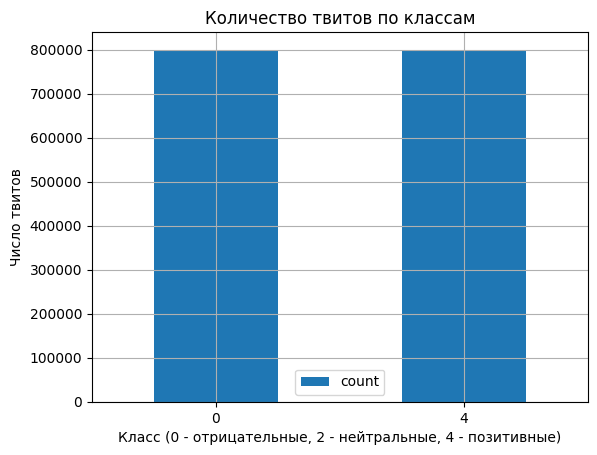

In [13]:
data['target'].value_counts().plot(
    kind='bar',
    rot=0,
    title='Количество твитов по классам',
    xlabel='Класс (0 - отрицательные, 2 - нейтральные, 4 - позитивные)',
    ylabel='Число твитов',
    legend=True,
    grid=True
)

Класса получается всего 2, поэтому мы будем делать бинарную классификацию. Заменим метку класса 4 на 1:

In [14]:
data['target'] = data['target'].replace(4,1)

In [15]:
def print_info_about_dataset(data):
    df = data.groupby(['target']).transform(lambda x: ' '.join(x)).drop_duplicates()

    fig = plt.figure()
    text0 = df['text'][0]
    cloud = WordCloud().generate(text0)
    plt.imshow(cloud)
    plt.title('Облако слов для класса 0')
    plt.axis('off')

    fig = plt.figure()
    text1 = df['text'][800000]
    cloud = WordCloud().generate(text1)
    plt.imshow(cloud)
    plt.title('Облако слов для класса 1')
    plt.axis('off')

    fig = plt.figure()
    cloud = WordCloud().generate(text0 + text1)
    plt.imshow(cloud)
    plt.title('Облако слов для всех твитов')
    plt.axis('off')

    df = pd.DataFrame({'x':['All', '0', '1'], 'y':[data['text'].str.len().mean(), data.loc[data['target'].eq(0),'text'].str.len().mean(), data.loc[data['target'].eq(1),'text'].str.len().mean()]})
    ax = df.plot.bar(
        x='x',
        y='y',
        rot=0,
        title='Средняя длина твитов по классам',
        xlabel='Класс (0 - отрицательные, 1 - позитивные)',
        grid=True
    )
    ax.bar_label(ax.containers[0])

CPU times: user 4min 16s, sys: 9.27 s, total: 4min 25s
Wall time: 4min 26s


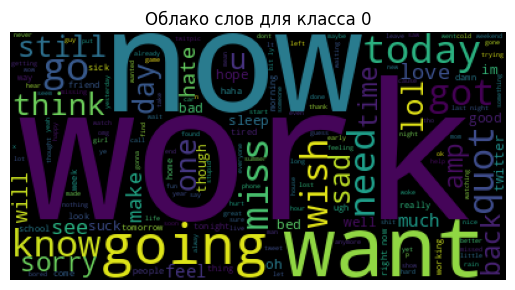

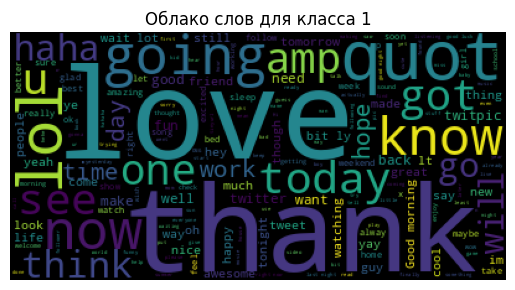

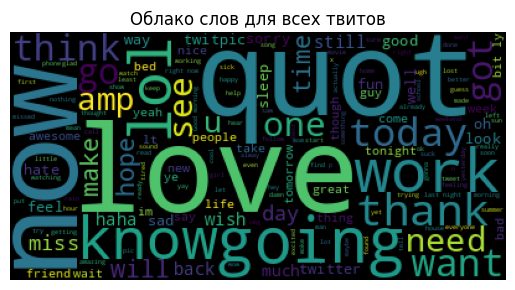

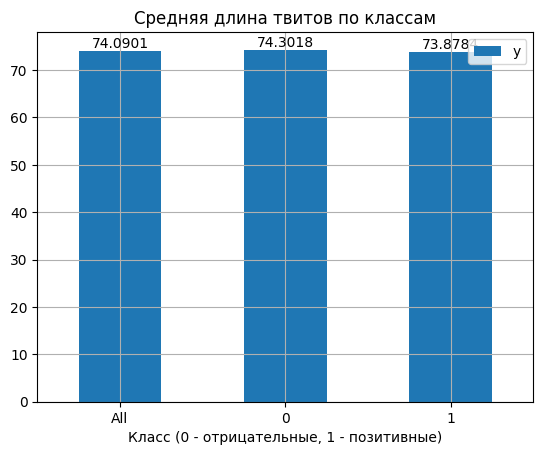

In [16]:
%%time

print_info_about_dataset(data)

У разных классов самые частотные слова по большей части совпадают, а средняя длина твитов почти не отличается, поэтому ориентироваться на эти параметры при классификации не стоит.

## Предобработка данных

In [17]:
print(STOPWORDS)

frozenset({'be', 'my', 'part', 'its', 'latter', 'how', 'down', 'kg', 'go', 'ten', 'beforehand', 'becoming', 'hereby', 'her', 'itself', 'much', 'those', 'seemed', 'twenty', 'say', 'along', 'nowhere', 'detail', 'their', 'his', 'whence', 'noone', 'she', 'nothing', 'enough', 'each', 'sincere', 'fifteen', 'various', 'might', 'namely', 'hereupon', 'neither', 'either', 'whither', 'any', 'take', 'con', 'eight', 'me', 'cry', 'bottom', 'same', 'empty', 'being', 'did', 'amongst', 'ourselves', 'move', 'alone', 'around', 'whereby', 'or', 'further', 'none', 'has', 'more', 'sometime', 'always', 'then', 'both', 'yours', 'with', 'it', 'i', 'couldnt', 'few', 'un', 'using', 'two', 'if', 'another', 'against', 'between', 'hasnt', 'when', 'again', 'next', 'de', 'three', 'from', 'nor', 'amoungst', 'only', 'hence', 'seems', 'side', 'first', 'several', 'top', 'after', 'under', 'into', 'just', 'he', 'they', 'over', 'system', 'whole', 'than', 'one', 'anyway', 'during', 'amount', 'himself', 'see', 'before', 'onto

Данные стоп слова вряд ли влияют на настроение твита, так что возьму их прямо из коробки.

In [19]:
%%time
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    text = remove_stopwords(text)
    return text.lower().replace('\s\s+', ' ')

data['cleaned_text'] = data.apply(preprocess_tweet, axis=1)

CPU times: user 5min 7s, sys: 737 ms, total: 5min 8s
Wall time: 5min 8s


In [21]:
data.sample(10)

,target,text,cleaned_text
625182,0,#inaperfectworld there would be no such thing ...,thing flu! my friend sick come tomorrow
415910,0,@pressdarling Oh that is horrible. So very s...,oh horrible. so sadly loss.
463790,0,@DJHiiDef lol ii dnt know how to wrk this shit...,lol ii dnt know wrk shit wanna
348009,0,Well here I'am at work time to act like I kno...,well i'am work time act like i know hehe long ...
1193641,1,"Finished watching Rent, in tears, now onto The...","finished watching rent, tears, the producers c..."
1423534,1,Date Night then racing the Nike Women's 5k in...,date night racing nike women's k morning...
1379445,1,@Dog_Crazy on my Youtube page. i am ok cuz i k...,youtube page. ok cuz know am. thanks
521197,0,only went in for exam then came home still ill !,went exam came home ill !
65039,0,studyin have a test tomorrow,studyin test tomorrow
1036773,1,goood morning !,goood morning !


Информация про датасет после удаления стоп-слов:

In [22]:
data = data.drop(columns=['text'])
data = data.rename(columns={'cleaned_text':'text'})
data.sample(10)

,target,text
930888,1,epic
534071,0,"good shower, figured i friends sad times."
588372,0,crying... im ready big change. its scary...
1435271,1,"queezy little side, i'm going play board/card ..."
1265713,1,oh i love melatonin.
1463289,1,glad twitter
67249,0,why weekends short...it feels like got started...
825568,1,goodmorning people lovely day
621414,0,"yea! good! email it. i disappointed night, goo..."
348901,0,ughh...work hour..boo


CPU times: user 3min 33s, sys: 10.8 s, total: 3min 44s
Wall time: 3min 44s


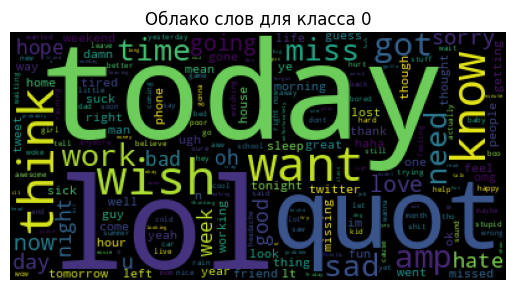

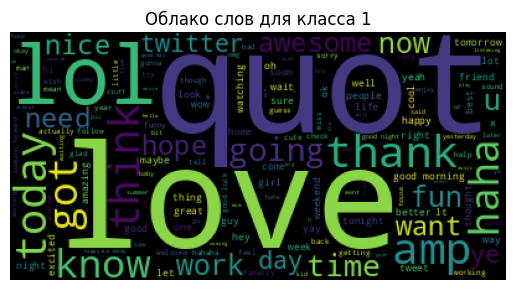

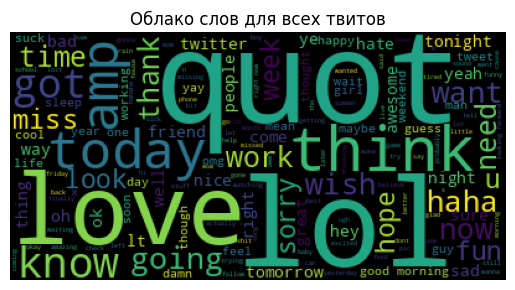

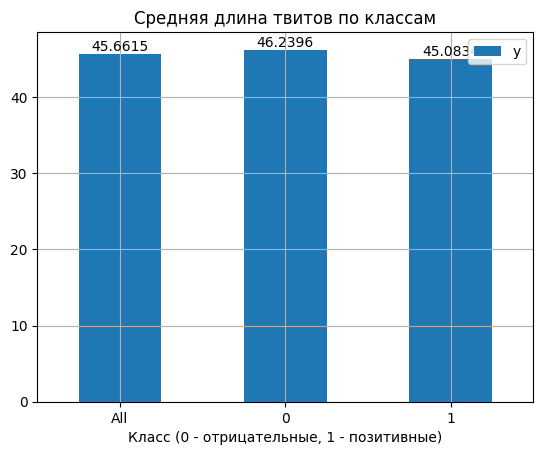

In [23]:
%%time

print_info_about_dataset(data)

Можно было удалить еще некоторые часто встречающиеся слова, но вряд ли они нам сильно помешают, давайте обучим модели и посмотрим. Средняя длина твита у разных классов все еще различается незначительно.

In [24]:
%%time

def preprocess_tweet(row):
    text = row['text']
    return text.encode('utf-8').split()

data['list_of_tokens'] = data.apply(preprocess_tweet, axis=1)

CPU times: user 22.5 s, sys: 676 ms, total: 23.1 s
Wall time: 23.2 s


## Извлечение признаков из текста с помощью векторизации

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data['list_of_tokens'], data['target'], random_state=seed)

In [26]:
%%time

VECTOR_SIZE = 256
model = gensim.models.FastText(
    sentences=X_train,
    vector_size=VECTOR_SIZE, # default = 100
    window=7, # default = 5
    min_count=10,
    sg=1, # Training algorithm: 1 for skip-gram; otherwise CBOW
    hs=0, #  If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
    negative=5, # If > 0, negative sampling will be used, if set to 0, no negative sampling is used.
    epochs=25, # Number of iterations (epochs) over the corpus
    seed=seed,
)

CPU times: user 2h 10min 42s, sys: 8.92 s, total: 2h 10min 50s
Wall time: 44min 31s


Получаем эмбеддинг для текста:

In [27]:
%%time

def document_vector(doc):
    doc = [model.wv[word.decode('UTF-8')] for word in doc if word in model.wv.key_to_index.keys()]
    if not doc:
        return [0 for i in range(VECTOR_SIZE)]
    return np.mean(doc, axis=0).tolist()

X_train_vectorized = list(X_train.apply(document_vector))
X_test_vectorized = list(X_test.apply(document_vector))

CPU times: user 9min 18s, sys: 37.5 s, total: 9min 56s
Wall time: 9min 57s


Построим 2d-визуализацию (преобразование 256-мерного пространства в 2d очень долго происходит на таком объеме данных, график можно найти в README.md)

In [29]:
# %%time

# tsne = TSNE(n_components=2, random_state=seed)
# X_test_tsne = tsne.fit_transform(np.array(X_test_vectorized))
# X_test_tsne.shape

In [30]:
# tsne.kl_divergence_

In [31]:
# fig = px.scatter(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], color=y_test)
# fig.update_layout(
#     title="t-SNE visualization",
#     xaxis_title="0",
#     yaxis_title="1",
# )
# fig.show()

Можно видеть, что классы перемешаны, вектора разных классов в 2d пространстве линейно неразделимы.

In [ ]:
# UMAP доллжен работать быстрее TSNE

# !pip install umap-learn[tbb]
# !pip install umap-learn[plot]

# import umap

# mapper = umap.UMAP().fit_transform(np.array(X_test_vectorized))
# umap.plot.points(mapper, labels=digits.target)

## Бейзлайн - константное предсказание

In [32]:
%%time

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=seed).fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67    199541
           1       0.00      0.00      0.00    200459

    accuracy                           0.50    400000
   macro avg       0.25      0.50      0.33    400000
weighted avg       0.25      0.50      0.33    400000

CPU times: user 774 ms, sys: 54.9 ms, total: 829 ms
Wall time: 831 ms


## Логистическая регрессия

In [33]:
%%time

logreg = LogisticRegression(random_state=seed, max_iter=1000).fit(X_train_vectorized, y_train)
preds_count_vec = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72    199541
           1       0.72      0.73      0.73    200459

    accuracy                           0.73    400000
   macro avg       0.73      0.73      0.73    400000
weighted avg       0.73      0.73      0.73    400000

CPU times: user 2min 10s, sys: 18.6 s, total: 2min 28s
Wall time: 1min 7s


## RandomForest

In [34]:
base_estimator = RandomForestClassifier(n_estimators=100, random_state=seed)

Подбор гиперпараметров с помощью HalvingGridSearchCV из sklearn:

In [35]:
param_grid = {'n_estimators':[50, 100],
              'max_depth': [3, 5, None],
              'min_samples_split': [2, 5],
              'random_state': [seed]}

In [36]:
%%time

sh = HalvingGridSearchCV(base_estimator,
                         param_grid,
                         cv=5,
                         factor=10,
                         scoring='accuracy',
                         n_jobs=-1,
                         random_state=seed)
sh.fit(X_train_vectorized[:10000], y_train[:10000])

CPU times: user 20.1 s, sys: 2.28 s, total: 22.4 s
Wall time: 59.3 s


HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=2023),
                    factor=10, n_jobs=-1,
                    param_grid={'max_depth': [3, 5, None],
                                'min_samples_split': [2, 5],
                                'n_estimators': [50, 100],
                                'random_state': [2023]},
                    random_state=2023, scoring='accuracy')

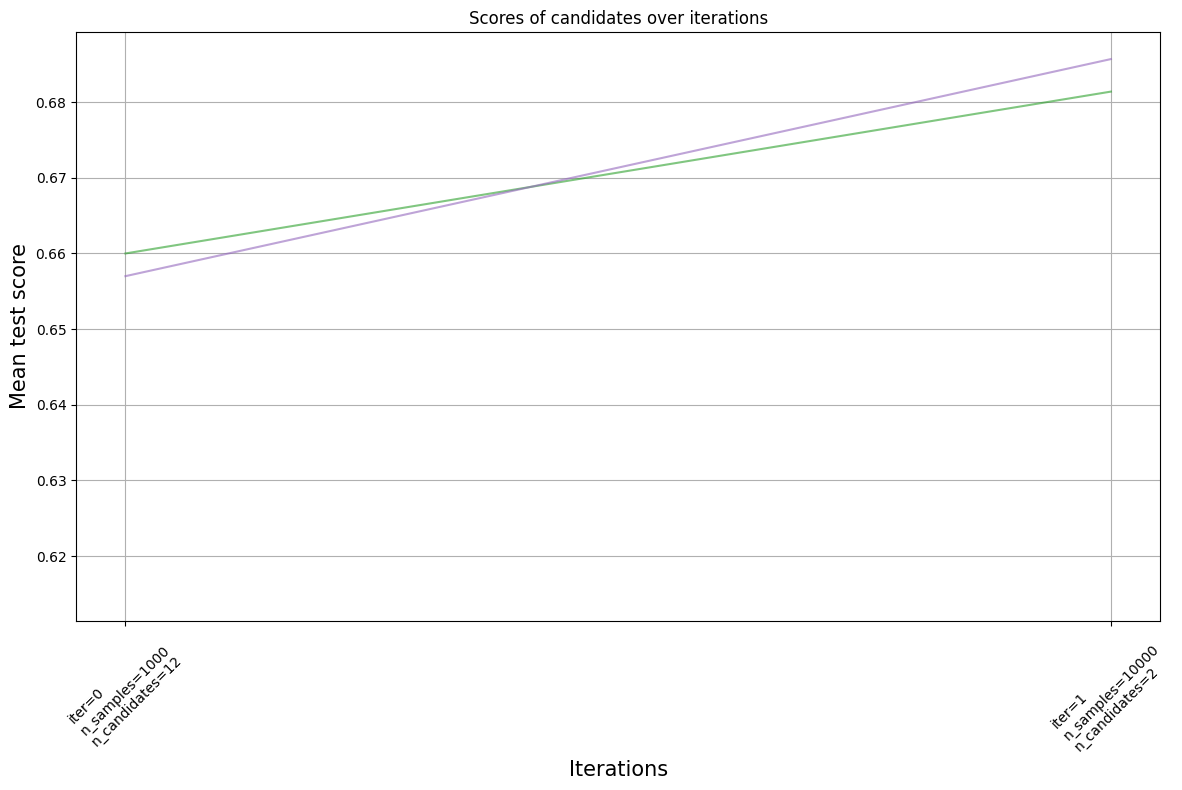

best_score: 0.6857


In [37]:
def plot(grid_search):
    plt.rcParams["figure.figsize"] = (12, 8)
    results = pd.DataFrame(grid_search.cv_results_)
    results["params_str"] = results.params.apply(str)
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter",
        columns="params_str",
        values="mean_test_score",
    )
    ax = mean_scores.plot(legend=False, alpha=0.6)

    labels = [
        f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
        for i in range(grid_search.n_iterations_)
    ]

    ax.set_xticks(range(grid_search.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("Mean test score", fontsize=15)
    ax.set_xlabel("Iterations", fontsize=15)
    plt.tight_layout()
    plt.grid()
    plt.show()

plot(sh)
print("best_score:", sh.best_score_)

In [38]:
sh.best_params_

{'max_depth': 5,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 2023}

In [39]:
best = sh.best_estimator_
y_pred = best.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70    199541
           1       0.71      0.63      0.67    200459

    accuracy                           0.69    400000
   macro avg       0.69      0.69      0.69    400000
weighted avg       0.69      0.69      0.69    400000



Подбор гиперпараметров с помощью optuna:

In [40]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])
    param_grid = {'n_estimators':trial.suggest_int("n_estimators", 50, 200),
                  'max_depth': trial.suggest_int("max_depth", 2, 32),
                  'min_samples_split': trial.suggest_int("min_samples_split", 2, 10)}
    classifier_obj = RandomForestClassifier(**param_grid, random_state=seed)

    score = cross_val_score(classifier_obj, X_train_vectorized[:10000], y_train[:10000], n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [41]:
%%time

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2023-12-30 19:57:22,139] A new study created in memory with name: no-name-0da09a2d-b520-41fb-82ac-60c3c19ab04a
[I 2023-12-30 19:57:30,456] Trial 0 finished with value: 0.6832010435596648 and parameters: {'classifier': 'RandomForest', 'n_estimators': 53, 'max_depth': 18, 'min_samples_split': 8}. Best is trial 0 with value: 0.6832010435596648.
[I 2023-12-30 19:57:50,527] Trial 1 finished with value: 0.6968005138846217 and parameters: {'classifier': 'RandomForest', 'n_estimators': 133, 'max_depth': 31, 'min_samples_split': 5}. Best is trial 1 with value: 0.6968005138846217.
[I 2023-12-30 19:58:18,228] Trial 2 finished with value: 0.699900553942617 and parameters: {'classifier': 'RandomForest', 'n_estimators': 187, 'max_depth': 17, 'min_samples_split': 10}. Best is trial 2 with value: 0.699900553942617.
[I 2023-12-30 19:58:40,671] Trial 3 finished with value: 0.7040008139986164 and parameters: {'classifier': 'RandomForest', 'n_estimators': 157, 'max_depth': 23, 'min_samples_split': 7}. 

CPU times: user 27.6 s, sys: 3.14 s, total: 30.8 s
Wall time: 17min 39s


In [42]:
print(study.best_trial)

FrozenTrial(number=7, state=TrialState.COMPLETE, values=[0.7040999540865904], datetime_start=datetime.datetime(2023, 12, 30, 19, 59, 47, 552405), datetime_complete=datetime.datetime(2023, 12, 30, 20, 0, 10, 647599), params={'classifier': 'RandomForest', 'n_estimators': 157, 'max_depth': 29, 'min_samples_split': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'n_estimators': IntDistribution(high=200, log=False, low=50, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=7, value=None)


In [43]:
plot_optimization_history(study)

In [44]:
plot_slice(study)

In [45]:
best_params = study.best_params
best_params.pop('classifier')
best_params

{'n_estimators': 157, 'max_depth': 29, 'min_samples_split': 10}

In [46]:
%%time

best_optuna = RandomForestClassifier(**best_params, random_state=seed).fit(X_train_vectorized[:10000], y_train[:10000])
y_pred = best_optuna.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70    199541
           1       0.71      0.68      0.70    200459

    accuracy                           0.70    400000
   macro avg       0.70      0.70      0.70    400000
weighted avg       0.70      0.70      0.70    400000

CPU times: user 51 s, sys: 160 ms, total: 51.2 s
Wall time: 51.2 s
